In [2]:
import os
import csv
import numpy as np
import random

import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from skimage import data,exposure
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint

import sklearn
from sklearn.metrics import roc_curve, auc 
import matplotlib.pyplot as plt

import sklearn.metrics as metrics

In [3]:
# cv => train:val = 4:1
mon = os.listdir('/home/stevenlai/Desktop/chexnet/database/MON/')
TB = []
non_TB = []

for pngname in mon:
    if pngname.split('.')[0].split('_')[-1] == '0':
        non_TB.append(pngname)
    else:
        TB.append(pngname)
print('TB image(should be 58):',len(TB))
print('non_TB image(should be 80):',len(non_TB))

# Shuffle the list
random.seed(10)  
random.shuffle(TB)
random.shuffle(non_TB)

# open csv
traincsv = open('/home/stevenlai/Desktop/chexnet_tensorflow/MON/dataset/train.csv','w')
trainwriter = csv.writer(traincsv)
trainwriter.writerow(['path','label'])


testcsv = open('/home/stevenlai/Desktop/chexnet_tensorflow/MON/dataset/test.csv','w')
testwriter = csv.writer(testcsv)
testwriter.writerow(['path','label'])

# TB:9 for test
# non TB: 13 for test
for i in range(len(TB)):
    if i < 9:
        testwriter.writerow(['MON/'+TB[i],1])
    else:
        trainwriter.writerow(['MON/'+TB[i],1])
    
for i in range(len(non_TB)):
    if i < 13:
        testwriter.writerow(['MON/'+non_TB[i],0])
    else:
        trainwriter.writerow(['MON/'+non_TB[i],0])

traincsv.close()
testcsv.close()

TB image(should be 58): 58
non_TB image(should be 80): 80


[  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  20
  21  22  23  24  26  27  29  30  31  34  35  36  37  39  40  41  42  43
  44  46  48  49  50  52  53  54  56  58  59  60  62  63  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  81  83  84  85  86  88  89
  90  92  93  94  95  97  98  99 100 102 103 104 105 106 107 108 109 111
 113 115] 0
[  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  20
  21  22  23  24  26  27  29  30  31  34  35  36  37  39  40  41  42  43
  44  46  48  49  50  52  53  54  56  58  59  60  62  63  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  81  83  84  85  86  88  89
  90  92  93  94  95  97  98  99 100 102 103 104 105 106 107 108 109 111
 113 115   0] 1
[  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  20
  21  22  23  24  26  27  29  30  31  34  35  36  37  39  40  41  42  43
  44  46  48  49  50  52  53  54  56  58  59  60  62  63  65  66  67  68
  69  70  71  72  73  7

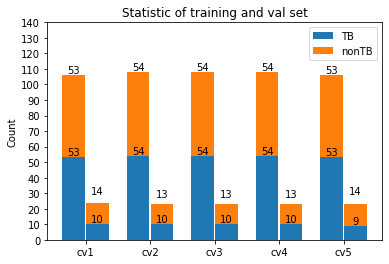

In [25]:
# read in csv and do k fold
df = pd.read_csv('/home/stevenlai/Desktop/chexnet_tensorflow/MON/dataset/train.csv')
X = df[['path']]
Y = df[['label']]
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 
trTB = []
trnTB = []
valTB = []
valnTB = []

for x,y in skf.split(X,Y):
    TB_count = 0
    non_TB_count = 0
    
    val_TB_count = 0
    val_non_TB_count = 0
    
    #print('train(~=92):',len(x))
    #print('val(~=24):',len(y))
    
    for i in x:
        if (Y.iloc[i,0]) == 1:
            TB_count += 1
        else:
            non_TB_count += 1
    #print('TB:',TB_count)
    #trTB.append(TB_count)
    #print('non TB:',non_TB_count)
    #trnTB.append(non_TB_count)
    #print()
    
    # imbalance by simply adding up
    imbalance = non_TB_count - TB_count
    #print(non_TB_count,TB_count)
    add = 0
    for i in range(len(x)):
        #print(Y.iloc[x[i]][0])
        if Y.iloc[x[i]][0] == 1:
            x = np.append(x,x[i])
            
            #print(len(x))
            #print(X.iloc[x[i]][0])
            add += 1
        if add == imbalance:
            break
            
    TB_count = 0
    non_TB_count = 0           
    for i in x:
        if (Y.iloc[i,0]) == 1:
            TB_count += 1
        else:
            non_TB_count += 1
    #print('TB:',TB_count)
    trTB.append(TB_count)
    #print('non TB:',non_TB_count)
    trnTB.append(non_TB_count)
    #print()    
    
    
    for i in y:
        if (Y.iloc[i,0]) == 1:
            val_TB_count += 1
        else:
            val_non_TB_count += 1
    #print('TB:',TB_count)
    valTB.append(val_TB_count)
    #print('non TB:',non_TB_count)
    valnTB.append(val_non_TB_count)
    #print()
    
# bar plot
labels = ['cv1','cv2','cv3','cv4','cv5']
N = 5

ind = np.arange(N)  
width = 0.35       
x = np.arange(len(labels)) 
p1 = plt.bar(x - width/2 - 0.01, trTB, width ,label='TB')
p2 = plt.bar(x - width/2 - 0.01, trnTB, width, bottom = trTB,label='non TB')
p3 = plt.bar(x + width/2 + 0.01, valTB, width, color=p1[0].get_facecolor())
p4 = plt.bar(x + width/2 + 0.01, valnTB, width, bottom = valTB,label='non TB',
            color=p2[0].get_facecolor())

plt.ylabel('Count')
plt.title('Statistic of training and val set')
plt.xticks(ind,labels)
plt.yticks(np.arange(0, 141, 10))
plt.legend()
plt.legend((p1[0], p2[0]), ('TB', 'nonTB'))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.*height,
                '%d' % int(height),
                ha='center', va='bottom')
def autolabel2(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 2.0*height,
                '%d' % int(height),
                ha='center', va='bottom')
autolabel(p1)
autolabel2(p2)
autolabel(p3)
autolabel2(p4)

plt.show()

In [5]:
from skimage.io import imread
from skimage.transform import rescale, resize

In [6]:
# file:///home/stevenlai/Downloads/28288-31036-1-PB.pdf
# http://europepmc.org/article/PMC/4335146
def CLAHE(img):
    img = img[:,:,0]
    img = img / 255
    #p2, p98 = np.percentile(img, (2, 98))
    #img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    #img_adapteq = np.expand_dims(img_adapteq,axis=2)
    rgb_batch = np.repeat(img_adapteq[..., np.newaxis], 3, -1)
    return rgb_batch

train_datagen = ImageDataGenerator(zoom_range = 0.1,
                                   preprocessing_function=CLAHE)

In [7]:
# VGG preprocess
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input) 

Found 92 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
(224, 224, 3)
[0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1.]


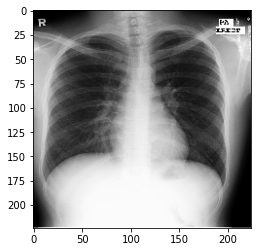

In [23]:
# CLAHE
image_dir = '/home/stevenlai/Desktop/chexnet/database/'
df['label'] = df['label'].astype(str)
for train_index, val_index in skf.split(X,Y):
    training_data = df.iloc[train_index]
    validation_data = df.iloc[val_index]
    
    train_data_generator = train_datagen.flow_from_dataframe(training_data, 
                                                             directory = image_dir,
                                                             x_col = "path", 
                                                             y_col = "label",
                                                             class_mode = "binary" ,
                                                             shuffle = True,
                                                             #color_mode = 'grayscale',
                                                             target_size = (224,224),
                                                             batch_size = 16,
                                                             seed = 10)
    val_data_generator = train_datagen.flow_from_dataframe(validation_data,
                                                           directory = image_dir,
                                                           x_col = "path", 
                                                           y_col = "label",
                                                           class_mode = "binary" ,
                                                           shuffle = True,
                                                           #color_mode = 'grayscale',
                                                           target_size = (224,224),
                                                           batch_size = 16,
                                                           seed = 10)    
    for (x,y) in train_data_generator :
        print(x[0].shape)
        print(y)
        plt.imshow(x[0][:,:,0], cmap=plt.cm.gray)
        plt.show()
        break
    break

Found 92 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
(224, 224, 3)
[0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1.]


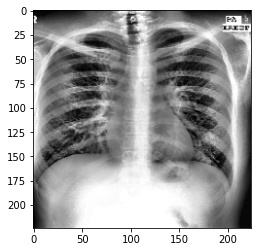

In [8]:
# vgg
image_dir = '/home/stevenlai/Desktop/chexnet/database/'
df['label'] = df['label'].astype(str)
for train_index, val_index in skf.split(X,Y):
    training_data = df.iloc[train_index]
    validation_data = df.iloc[val_index]
    
    train_data_generator = train_datagen.flow_from_dataframe(training_data, 
                                                             directory = image_dir,
                                                             x_col = "path", 
                                                             y_col = "label",
                                                             class_mode = "binary" ,
                                                             shuffle = True,
                                                             #color_mode = 'grayscale',
                                                             target_size = (224,224),
                                                             batch_size = 16,
                                                             seed = 10)
    val_data_generator = train_datagen.flow_from_dataframe(validation_data,
                                                           directory = image_dir,
                                                           x_col = "path", 
                                                           y_col = "label",
                                                           class_mode = "binary" ,
                                                           shuffle = True,
                                                           #color_mode = 'grayscale',
                                                           target_size = (224,224),
                                                           batch_size = 16,
                                                           seed = 10)    
    for (x,y) in train_data_generator :
        print(x[0].shape)
        print(y)
        plt.imshow(x[0][:,:,0], cmap=plt.cm.gray)
        plt.show()
        break
    break

In [7]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = True
top_model = tf.keras.models.Sequential()
top_model.add(tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(tf.keras.layers.Dropout(0.5))
top_model.add(tf.keras.layers.Dense(64, kernel_initializer='normal'))
top_model.add(tf.keras.layers.BatchNormalization())
top_model.add(tf.keras.layers.Activation('relu'))
top_model.add(tf.keras.layers.Dense(64, kernel_initializer='normal'))
top_model.add(tf.keras.layers.BatchNormalization())
top_model.add(tf.keras.layers.Activation('relu'))
top_model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model = tf.keras.models.Model(base_model.inputs, top_model(base_model.output))
#model.summary()

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [11]:
reduce_lr = ReduceLROnPlateau(factor = 0.5,
                              monitor = 'val_loss',
                              min_lr = 0.000001,
                              patience = 10,
                              verbose = 1)
filepath = os.path.join('/home/stevenlai/Desktop/chexnet_tensorflow/MON/model',"DenseNet_Trainable_CLAHE_MON.hdf5")
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto')

In [12]:
#VGG16 preprocess
#train_step = 106(after balance) / 16(batch size) = 7
#val_step = 23 / 16 = 2
model_history = model.fit(train_data_generator,
                          steps_per_epoch=6,
                          epochs=20,
                          validation_data=val_data_generator,
                          validation_steps=2,
                          verbose=1,
                          callbacks=[reduce_lr,checkpoint]
                          )

Epoch 1/20
6/6 [==============================] - ETA: 0s - loss: 0.6742 - acc: 0.6196
Epoch 00001: val_acc improved from -inf to 0.58333, saving model to /home/stevenlai/Desktop/chexnet_tensorflow/MON/model/DenseNet_Trainable_CLAHE_MON.hdf5
6/6 [==============================] - 83s 14s/step - loss: 0.6742 - acc: 0.6196 - val_loss: 0.9236 - val_acc: 0.5833 - lr: 0.0010
Epoch 2/20
6/6 [==============================] - ETA: 0s - loss: 0.4488 - acc: 0.8152
Epoch 00002: val_acc did not improve from 0.58333
6/6 [==============================] - 75s 13s/step - loss: 0.4488 - acc: 0.8152 - val_loss: 1.9441 - val_acc: 0.5833 - lr: 0.0010
Epoch 3/20
6/6 [==============================] - ETA: 0s - loss: 0.3156 - acc: 0.8804
Epoch 00003: val_acc did not improve from 0.58333
6/6 [==============================] - 75s 12s/step - loss: 0.3156 - acc: 0.8804 - val_loss: 6.0864 - val_acc: 0.5833 - lr: 0.0010
Epoch 4/20
6/6 [==============================] - ETA: 0s - loss: 0.2394 - acc: 0.9348
Epoc

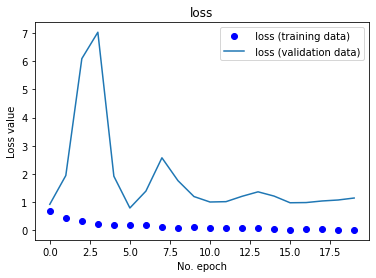

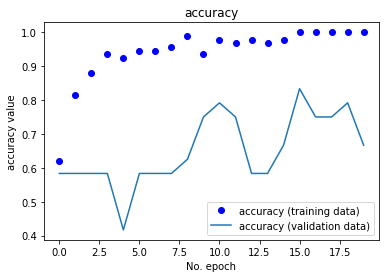

In [13]:
# Plot
plt.title('loss')
plt.plot(model_history.history['loss'],'bo', label=' loss (training data)')
plt.plot(model_history.history['val_loss'], label=' loss (validation data)')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.savefig('/home/stevenlai/Desktop/chexnet_tensorflow/MON/plot/DenseNet_Trainable_CLAHE_MON_loss.jpg')
plt.show()
plt.close('all')

plt.title('accuracy')
plt.plot(model_history.history['acc'],'bo', label='accuracy (training data)')
plt.plot(model_history.history['val_acc'], label='accuracy (validation data)')
plt.ylabel('accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.savefig('/home/stevenlai/Desktop/chexnet_tensorflow/MON/plot/DenseNet_Trainable_CLAHE_MON_acc.jpg')
plt.show()
plt.close('all')

In [17]:
df = pd.read_csv('/home/stevenlai/Desktop/chexnet_tensorflow/MON/dataset/test.csv')
df['label'] = df['label'].astype(str)
test_generator=train_datagen.flow_from_dataframe(
    dataframe=df, 
    directory=image_dir,
    x_col="path",
    y_col= "label",
    class_mode="binary",
    target_size=(224,224),
    batch_size=1,
    Seed = 501009,
    shuffle = False
)
test_generator.reset()

Found 22 validated image filenames belonging to 2 classes.


In [18]:
model = tf.keras.models.load_model('/home/stevenlai/Desktop/chexnet_tensorflow/MON/model/DenseNet_Trainable_CLAHE_MON.hdf5')
y_test=model.predict(test_generator,verbose=1)

22/22 [==============================] - 7s 332ms/step


<Figure size 432x288 with 0 Axes>

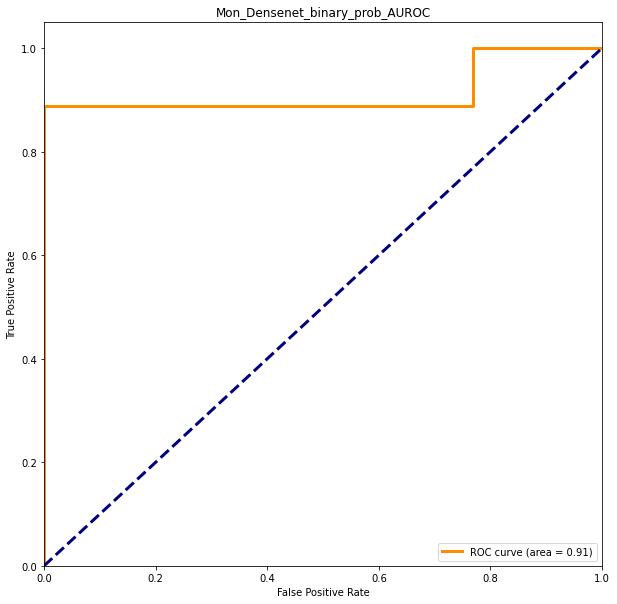

In [53]:
y_label = np.array(df['label'].astype(float))
y_pred = np.concatenate(y_test)
fpr,tpr,_ =sklearn.metrics.roc_curve(y_label,y_pred)
roc_auc = auc(fpr,tpr) 
plt.figure()
lw = 3
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mon_Densenet_binary_prob_AUROC')
plt.legend(loc="lower right")
plt.savefig('/home/stevenlai/Desktop/chexnet_tensorflow/MON/plot/Mon_Densenet_binary_prob_AUROC.jpg')
plt.show()

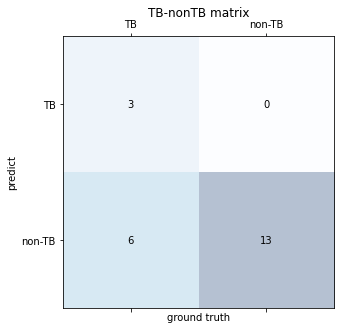

In [100]:
# Set threshold = 0.5 and evalute + xlsx + Matrix
y_pred_half = []
output_matrix = np.array([[0,0],[0,0]])
for i in range(len(y_pred)):
    if y_pred[i] >= 0.5:
        y_pred_half.append(1)
    else :y_pred_half.append(0)
        
# save filename
name = df['path']

# output csv
outputdir = open('/home/stevenlai/Desktop/chexnet_tensorflow/MON/result/MON.csv','w')
csvwriter = csv.writer(outputdir)
csvwriter.writerow(['file','ground truth','predict'])
for i in range(len(name)):
    csvwriter.writerow([name[i],y_label[i],y_pred_half[i]])
outputdir.close()

confusion_matrix = metrics.confusion_matrix(y_true=y_label, y_pred = y_pred_half)
confusion_matrix
output_matrix[0][0] = confusion_matrix[1][1]
output_matrix[0][1] = confusion_matrix[0][1]
output_matrix[1][0] = confusion_matrix[1][0]
output_matrix[1][1] = confusion_matrix[0][0]

fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(output_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(2):
    for j in range(2):
        ax.text(i, j, s = output_matrix.T[i, j], va='center', ha='center')
plt.title('TB-nonTB matrix')
plt.xlabel('ground truth')        
plt.ylabel('predict')
labels = ['TB','non-TB']
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.savefig('/home/stevenlai/Desktop/chexnet_tensorflow/MON/plot/Mon_Densenet_binary_prob_matrix.jpg')
plt.show()

In [ ]:
# heatmap
